In [75]:
%load_ext tensorboard

In [80]:
import numpy as np
from matplotlib import pyplot as plt 
from matplotlib.pyplot import figure
from scipy.io import wavfile
import os
import pandas as pd
import re
from hashlib import sha1
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import tensorflow_model_optimization as tfmot
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sn
from tqdm import tqdm
from collections import Counter
import time
import tempfile
import datetime


In [4]:
MAX_NUM_WAVS_PER_CLASS = 2**27 - 1  # ~134M

def which_set(filename, validation_percentage, testing_percentage):
    """
  Helper function when downloading dataset that determines which data partition the file should belong to.

  We want to keep files in the same training, validation, or testing sets even
  if new ones are added over time. This makes it less likely that testing
  samples will accidentally be reused in training when long runs are restarted
  for example. To keep this stability, a hash of the filename is taken and used
  to determine which set it should belong to. This determination only depends on
  the name and the set proportions, so it won't change as other files are added.

  It's also useful to associate particular files as related (for example words
  spoken by the same person), so anything after '_nohash_' in a filename is
  ignored for set determination. This ensures that 'bobby_nohash_0.wav' and
  'bobby_nohash_1.wav' are always in the same set, for example.

  Args:
    filename: File path of the data sample.
    validation_percentage: How much of the data set to use for validation.
    testing_percentage: How much of the data set to use for testing.

  Returns:
    String, one of 'training', 'validation', or 'testing'.
  """


    base_name = os.path.basename(filename)

      # We want to ignore anything after '_nohash_' in the file name when
      # deciding which set to put a wav in, so the data set creator has a way of
      # grouping wavs that are close variations of each other.

    hash_name = re.sub(r'_nohash_.*$', '', base_name).encode('utf-8')

      # This looks a bit magical, but we need to decide whether this file should
      # go into the training, testing, or validation sets, and we want to keep
      # existing files in the same set even if more files are subsequently
      # added.
      # To do that, we need a stable way of deciding based on just the file name
      # itself, so we do a hash of that and then use that to generate a
      # probability value that we use to assign it.

    hash_name_hashed = hashlib.sha1(hash_name).hexdigest()
    percentage_hash = int(hash_name_hashed, 16) % (MAX_NUM_WAVS_PER_CLASS
            + 1) * (100.0 / MAX_NUM_WAVS_PER_CLASS)
    if percentage_hash < validation_percentage:
        result = 'validation'
    elif percentage_hash < testing_percentage + validation_percentage:
        result = 'testing'
    else:
        result = 'training'
    return result

In [5]:
def get_labels(dataset_list):
    """
Samples are the files themselves upon which we will apply a feature extraction function.
Labels are the parent directories of the file. Thus, this function returns the label of a given wav file. 
Function takes as input either a text file containing wav file paths OR a list of wav file paths.  
    """
    training_labels = []
    if type(dataset_list) == list:
        for file in dataset_list:
            training_labels.append(os.path.dirname(file))
        return np.asarray(training_labels)
    
    elif os.path.isfile(dataset_list):
        with open(dataset_list) as f:
            dataset_files = f.readlines()
            for file in dataset_files:
                training_labels.append(os.path.dirname(file))
        return np.asarray(training_labels)
    else:
        return "Sorry, wrong input format provided"
        

In [6]:
def create_training_txt_file(dataset_path):
    
    with open(os.path.join(dataset_path, 'testing_list.txt')) as f:
        testing_files = f.read().splitlines()


    with open(os.path.join(dataset_path, 'validation_list.txt')) as f:
        validation_files = f.read().splitlines()
        
    complete_dataset = []
    with open(os.path.join(dataset_path, 'training_list.txt'), "w") as train_f:
        list_of_local_dirs = [folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))]
        for folder in list_of_local_dirs:
            for file in os.listdir(folder_path):
                if which_set(os.path.join(folder,file), 10, 10) == "training":
                    train_f.write(f"{os.path.join(folder, file)}\n")
        
                    
        
        
        
        
        
        
        
        
        
        
        
        
        
        

In [7]:
def load_audio_data(training_list_path, training_labels_encoded, testing_list_path, testing_labels_encoded, validation_list_path, validation_labels_encoded):
    
    size_of_sample_considered = 1 #length of the audio file in seconds
    fs = 16000 #the stipulated sampling rate according to the dataset description 
    segmentLength = 1024 # no. of samples to use per segment window 
    adjusted_sample_length = int(size_of_sample_considered*fs/segmentLength)*segmentLength # size of audio sample adjusted to be a power of 2. 

    with open(training_list_path) as f1:
        X_training_audio_dataset_paths = f1.read().splitlines()
        
    with open(testing_list_path) as f2:
        X_testing_audio_dataset_paths = f2.read().splitlines()
        
    with open(validation_list_path) as f3:
        X_validation_audio_dataset_paths = f3.read().splitlines()
    
    
    def get_stratified_sample(audio_file_paths, audio_file_labels, fraction):
        X_stratified, _, y_stratified, _ = train_test_split(audio_file_paths,audio_file_labels, train_size = fraction, stratify = audio_file_labels)
        return X_stratified, y_stratified
        
    Training_size = 80000
    fraction_of_original_size = float(Training_size)/len(X_training_audio_dataset_paths)
    
    X_training_audio_dataset_paths, y_train = get_stratified_sample(X_training_audio_dataset_paths, training_labels_encoded, fraction_of_original_size)
    
    y_test = testing_labels_encoded 
    y_val = validation_labels_encoded
    
    X_train_wav = []
    X_test_wav = []
    X_val_wav = []
    

    
    for i in tqdm(range(Training_size)):
        try: 
            fs, train_sample_wav = wavfile.read(os.path.join(dataset_path, X_training_audio_dataset_paths[i]))
        except ValueError:
            print(os.path.join(dataset_path, X_training_audio_dataset_paths[i]))
            pass
            
        _dummy_sample_wav = train_sample_wav.copy() # get copy of wav file that you can modify
        _dummy_sample_wav.resize(adjusted_sample_length)
        _dummy_sample_wav = _dummy_sample_wav.reshape(-1, segmentLength)
        X_train_wav.append(_dummy_sample_wav.astype(np.float32))

        
        
    for i in tqdm(range(len(X_testing_audio_dataset_paths))):
        fs, test_sample_wav = wavfile.read(os.path.join(dataset_path, X_testing_audio_dataset_paths[i]))
        _dummy_sample_wav = test_sample_wav.copy()
        _dummy_sample_wav.resize(adjusted_sample_length)
        _dummy_sample_wav = _dummy_sample_wav.reshape(-1, segmentLength)
        X_test_wav.append(_dummy_sample_wav.astype(np.float32))
        
        
    for i in tqdm(range(len(X_validation_audio_dataset_paths))):
        fs, val_sample_wav = wavfile.read(os.path.join(dataset_path, X_validation_audio_dataset_paths[i]))
        _dummy_sample_wav = val_sample_wav.copy()
        _dummy_sample_wav.resize(adjusted_sample_length)
        _dummy_sample_wav = _dummy_sample_wav.reshape(-1, segmentLength)
        X_val_wav.append(_dummy_sample_wav.astype(np.float32))
        
        
    return X_train_wav, X_test_wav, X_val_wav, y_train, y_test, y_val
    
    

    
    
    
        

In [8]:
def compute_mfccs(samples, fs, upper_edge_hz, lower_edge_hz, num_mel_bins, num_mfcc):
    frame_length = 1024
    stfts = tf.signal.stft(samples, frame_length=frame_length, frame_step=frame_length, fft_length=frame_length) # no overlap
    spectrograms = tf.abs(stfts)
    spectrograms = tf.reshape(spectrograms, (spectrograms.shape[0],spectrograms.shape[1],-1))
    num_spectrogram_bins = stfts.shape[-1]
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(num_mel_bins, num_spectrogram_bins, fs, lower_edge_hz, upper_edge_hz)
    mel_spectrograms = tf.tensordot(spectrograms, linear_to_mel_weight_matrix, 1)
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :num_mfcc]
    return tf.reshape(mfccs, (mfccs.shape[0],mfccs.shape[1],mfccs.shape[2],-1))



## Handling Creation of Text Files containing Samples for Training, Testing and Validation

In [9]:
global dataset_path
dataset_path = os.path.join("speech_commands_v0.02")
training_dataset_path = os.path.join(dataset_path, "training_list.txt")
testing_dataset_path = os.path.join(dataset_path, "testing_list.txt")
validation_dataset_path = os.path.join(dataset_path, "validation_list.txt")
if not os.path.exists(training_dataset_path):
    create_training_txt_file(dataset_path)

In [10]:
testing_labels = get_labels(testing_dataset_path)
print(len(testing_labels))
training_labels = get_labels(training_dataset_path)
print(len(training_labels))
validation_labels = get_labels(validation_dataset_path)
print(len(validation_labels))

11005
84849
9981


## Ordinal Encoding of Labels

In [11]:
training_encoder = LabelEncoder()
training_encoder.fit(training_labels)
training_labels_encoded = training_encoder.transform(training_labels)

# training_encoder.fit(testing_labels)
testing_labels_encoded = training_encoder.transform(testing_labels)

validation_labels_encoded = training_encoder.transform(validation_labels)


print(training_encoder.classes_)

# sanity check


['_background_noise_' 'backward' 'bed' 'bird' 'cat' 'dog' 'down' 'eight'
 'five' 'follow' 'forward' 'four' 'go' 'happy' 'house' 'learn' 'left'
 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven' 'sheila' 'six'
 'stop' 'three' 'tree' 'two' 'up' 'visual' 'wow' 'yes' 'zero']


##  Getting an idea of class counts in Training and Testing Sets

In [12]:
print("Training:", Counter(training_labels))
print("\nTesting:", Counter(testing_labels))
print("\nValidation:", Counter(validation_labels))

print("\n",Counter(training_labels_encoded))
print("\n",Counter(testing_labels_encoded))

Training: Counter({'zero': 3250, 'five': 3240, 'yes': 3228, 'seven': 3205, 'nine': 3170, 'one': 3140, 'down': 3134, 'no': 3130, 'stop': 3111, 'two': 3111, 'go': 3106, 'six': 3088, 'on': 3086, 'left': 3037, 'eight': 3033, 'right': 3019, 'off': 2970, 'three': 2966, 'four': 2955, 'up': 2948, 'house': 1727, 'wow': 1724, 'dog': 1711, 'marvin': 1710, 'bird': 1697, 'cat': 1657, 'happy': 1632, 'sheila': 1606, 'bed': 1594, 'tree': 1407, 'backward': 1346, 'visual': 1288, 'learn': 1286, 'follow': 1275, 'forward': 1256, '_background_noise_': 6})

Testing: Counter({'five': 445, 'up': 425, 'two': 424, 'yes': 419, 'zero': 418, 'left': 412, 'stop': 411, 'eight': 408, 'nine': 408, 'seven': 406, 'down': 406, 'no': 405, 'three': 405, 'go': 402, 'off': 402, 'four': 400, 'one': 399, 'right': 396, 'on': 396, 'six': 394, 'dog': 220, 'sheila': 212, 'bed': 207, 'wow': 206, 'happy': 203, 'marvin': 195, 'cat': 194, 'tree': 193, 'house': 191, 'bird': 185, 'follow': 172, 'backward': 165, 'visual': 165, 'learn': 16

## Audio Processing Pipeline on WAV files

A little bit about the audio files at hand:
- We have a total of 105 829 audio files split in the following way for Training, Testing and Validation:
    - Training: 84850
    - Testing: 11005
    - Validation: 9981
- Each audio file was sampled at a 16000 Hz rate and each file is *trimmed down to one second length*. Thus per audio file, you can expect 16000 samples of information describing that file.
- The breakdown of classes found in each set is as follows:
    - Training Set: '_background_noise_','backward','bed','bird','cat','dog','down','eight','five','follow','forward','four','go','happy','house','learn','left','marvin','nine','no','off','on','one','right','seven','sheila','six','stop','three','tree','two' 'up','visual','wow','yes','zero'.
    - Testing Set: 'backward','bed','bird','cat','dog','down','eight','five','follow','forward','four','go','happy','house','learn','left','marvin','nine','no','off','on','one','right','seven','sheila','six','stop','three','tree','two' 'up','visual','wow','yes','zero'

In [13]:
X_train, X_test, X_val, y_train, y_test, y_val = load_audio_data(training_dataset_path, training_labels_encoded, testing_dataset_path, testing_labels_encoded, validation_dataset_path, validation_labels_encoded)

  1%|▏         | 1152/80000 [00:01<01:57, 668.81it/s]/usr/local/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
100%|██████████| 9981/9981 [00:13<00:00, 719.23it/s]


In [14]:
start = time.time()
X_train_mfccs = compute_mfccs(X_train, fs = 16000, upper_edge_hz = 8000.0, lower_edge_hz = 60.0, num_mel_bins = 80, num_mfcc = 13)
end = time.time()
print("MFCC extraction time:", end-start, "seconds")

MFCC extraction time: 384.44360089302063 seconds


In [15]:
start = time.time()
X_test_mfccs = compute_mfccs(X_test, fs = 16000, upper_edge_hz = 8000.0, lower_edge_hz = 60.0, num_mel_bins = 80, num_mfcc = 13)
end = time.time()
print("MFCC extraction time:", end-start, "seconds")

MFCC extraction time: 28.363176822662354 seconds


In [16]:
start = time.time()
X_val_mfccs = compute_mfccs(X_val, fs = 16000, upper_edge_hz = 8000.0, lower_edge_hz = 60.0, num_mel_bins = 80, num_mfcc = 13)
end = time.time()
print("MFCC extraction time:", end-start, "seconds")

MFCC extraction time: 28.321053981781006 seconds


In [17]:
print("X_train shape:", X_train_mfccs.shape)
print("X_test shape:", X_test_mfccs.shape)
print("X_val shape:", X_val_mfccs.shape)

X_train shape: (80000, 15, 13, 1)
X_test shape: (11005, 15, 13, 1)
X_val shape: (9981, 15, 13, 1)


## Initiation of Conv Neural Network Architecture

In [18]:
"""
Reasons we don't normalize to mean 0 and variance = 1:
The performance of CMVN is known to degrade for short utterances due to insufficient data for 
parameter estimation and loss of discriminable information as all utterances are forced to 
have zero mean and unit variance. This affects us as we're dealing with 1 second samples for 
training.
"""

batch_size = 32
epochs = 40

train_set = X_train_mfccs
train_labels = y_train

test_set = X_test_mfccs
test_labels = y_test

val_set = (X_val_mfccs)
val_labels = y_val



In [81]:
def train(batch_size, epochs, train_set, train_labels, val_set, val_labels):
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1) 
    model = tf.keras.models.Sequential()
    model.add(layers.InputLayer(input_shape=(train_set.shape[1],train_set.shape[2],train_set.shape[3]), batch_size= batch_size))
    model.add(layers.Conv2D(filters=3,kernel_size=(5,5),padding="same",input_shape=(train_set[0].shape)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    model.add(layers.Conv2D(filters=16,kernel_size=(3,3),padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    model.add(layers.MaxPool2D((2,2)))

    model.add(layers.Conv2D(filters=32,kernel_size=(3,3),padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    model.add(layers.MaxPool2D((4,4)))

    model.add(layers.Conv2D(filters=48,kernel_size=(3,3),padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Flatten())

    model.add(layers.Dense(8))
    model.add(layers.Activation('relu'))

    model.add(layers.Dense(36))
    model.add(layers.Activation('softmax'))


    model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
    model.fit(train_set, train_labels, batch_size, epochs, validation_data=(val_set, val_labels),callbacks=[tensorboard_callback])
    return model

In [82]:
def quantization_aware_training(model):
    q_aware_model = tfmot.quantization.keras.quantize_model(model) # q_aware stands for for quantization aware.
    q_aware_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy']) # `quantize_model` requires a recompile.
    return q_aware_model

In [85]:
%tensorboard --logdir logs

In [ ]:
print("Model Prepared for Quantization")
prepared_model = train(batch_size, 1, train_set, train_labels, val_set, val_labels)
print("\nOriginal Model trained without Quantization")
og_model = train(batch_size, epochs, train_set, train_labels, val_set, val_labels)

Model Prepared for Quantization
Train on 80000 samples, validate on 9981 samples
80000/80000 [==============================] - 48s 595us/sample - loss: 2.0334 - accuracy: 0.4099 - val_loss: 2.4506 - val_accuracy: 0.3301

Original Model trained without Quantization
Train on 80000 samples, validate on 9981 samples
Epoch 1/40
28112/80000 [=========>....................] - ETA: 30s - loss: 2.7962 - accuracy: 0.2109

In [ ]:
%tensorboard --q_aware_logdir q_aware_logs

In [ ]:

q_aware_logdir = os.path.join("q_aware_logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(q_aware_logdir, histogram_freq=1)
q_aware_model = quantization_aware_training(prepared_model)
q_aware_model.fit(train_set, train_labels, batch_size, epochs, validation_data=(val_set, val_labels), callbacks=[tensorboard_callback])

og_model.summary()

In [29]:
original_score = og_model.evaluate(test_set, test_labels, batch_size = 16, verbose = 0)
q_aware_score = q_aware_model.evaluate(test_set, test_labels, batch_size = 16, verbose = 0)
print("OG Trained Model Accuracy:", original_score[1]*100)
print("Quant-Aware Trained Model Accuracy:",q_aware_score[1]*100)


OG Trained Model Accuracy: 74.229896068573
Quant-Aware Trained Model Accuracy: 68.8959538936615


In [40]:
og_model.save("First_it.h5")

In [41]:
q_aware_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quant_conv2d_16 (QuantizeWra (None, 15, 13, 3)         85        
_________________________________________________________________
quant_batch_normalization_16 (None, 15, 13, 3)         13        
_________________________________________________________________
quant_activation_24 (Quantiz (None, 15, 13, 3)         3         
_________________________________________________________________
quant_conv2d_17 (QuantizeWra (None, 15, 13, 16)        481       
_________________________________________________________________
quant_batch_normalization_17 (None, 15, 13, 16)        65        
_________________________________________________________________
quant_activation_25 (Quantiz (None, 15, 13, 16)        3         
_________________________________________________________________
quant_max_pooling2d_8 (Quant (None, 7, 6, 16)         

In [32]:
#converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
#converter.optimizations = [tf.lite.Optimize.DEFAULT]

#quantized_tflite_model = converter.convert()


## Conversion of Model from .h file to TFLite file. 

Using the helper functions from the Week 6 lab dealing with MFCC coefficients, we complete the conversion process as follows

In [49]:
"""
Convert tensor types to numpy types prior to conversion
"""
def check_correct_type(input_set):
    assert type(input_set) == np.ndarray, f"Wrong type. Your set is of type {type(input_set)} when it should be np.ndarray"
check_correct_type(train_labels)
check_correct_type(train_set)
check_correct_type(test_labels)
check_correct_type(test_set)


# train_set = train_set.numpy()
# test_set = test_set.numpy()

In [50]:
model_name = "First_it" #name given to h5 file. 

In [51]:
def model_converter(model, train_set: np.ndarray, representative_dataset_size: int, model_name: str):
    """
Model conversion function derived from Week 6 lab to convert Keras model to TFLite, which
quantizes the weights of our model using 8-bit integer quantization.

Parameters:
    model: trained Keras model contained in .h5 file
    training_set: training set used to train Keras model
    representative_dataset_size: Integer value representing size of subset of dataset used to train 
        our model. It should only be a value around a few hundred as it only serves "to calibrate or estimate the range, 
        of floating-point arrays in the model (such as model input, activation outputs of intermediate layers, and model output) 
        for quantization." (TFLite Documentation)
    model_name: string value denoting the name of the file on which the Keras Model is persisted.
    
Outputs:
    No output as a result of this function call. New file created and persisted containing quantized
    model. Has '.tflite' extension.
"""
    converter = tf.lite.TFLiteConverter.from_keras_model(model) # Convert the model to the TensorFlow Lite format with quantization
    quantize = True
    if (quantize):
        def representative_dataset():
            for i in range(representative_dataset_size):
                yield([train_set[i].reshape(1,15,13,1)])
        # Set the optimization flag.
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
#         Enforce full-int8 quantization
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.int8  # or tf.uint8
        converter.inference_output_type = tf.int8  # or tf.uint8
        #Provide a representative dataset to ensure we quantize correctly.
    converter.representative_dataset = representative_dataset
    tflite_model = converter.convert()

    open(model_name + '.tflite', 'wb').write(tflite_model)
    return tflite_model

In [52]:
def hex_to_c_array(quantized_model, model_name):
    """
Lab Week 6 Function: Convert some hex value into an array for C programming.
Then write TFLite model to a C source (or header) file to be used on Cube AI platform.

Parameters:
    quantized model: contains weights quantized to 8 bit fixed-point representations.
    model_name: name of tflite model.  
    
    """
    c_str = ''

    # Create header guard
    c_str += '#ifndef ' + model_name.upper() + '_H\n'
    c_str += '#define ' + model_name.upper() + '_H\n\n'

    # Add array length at top of file
    c_str += '\nunsigned int ' + model_name + '_len = ' + str(len(quantized_model)) + ';\n'

    # Declare C variable
    c_str += 'unsigned char ' + model_name + '[] = {'
    hex_array = []
    for i, val in enumerate(quantized_model) :

        # Construct string from hex
        hex_str = format(val, '#04x')

        # Add formatting so each line stays within 80 characters
        if (i + 1) < len(quantized_model):
            hex_str += ','
        if (i + 1) % 12 == 0:
            hex_str += '\n '
        hex_array.append(hex_str)

    # Add closing brace
    c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'
    #print(c_str)

    # Close out header guard
    c_str += '#endif //' + model_name.upper() + '_H'
    with open(model_name + '.h', 'w') as file:
        file.write(c_str)

In [62]:
quantized_model = model_converter(og_model, train_set, 100, model_name)
hex_to_c_array(quantized_model, model_name)

In [72]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sn
def quantized_model_comparison(original_score, quantized_model, test_set, test_labels, label_encoder):
    """
Function inspired from Lab Week 6 to compute quality of network after quantization. 
    """
    interpreter = tf.lite.Interpreter(model_content=quantized_model)
    interpreter.allocate_tensors()
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
#     print("== Input details ==")
#     print("\n\n",input_details)
#     print("name:", input_details[0]['name'])
#     print("shape:", input_details[0]['shape'])
#     print("type:", input_details[0]['dtype'])

#     print("\n== Output details ==")
#     print("name:", output_details[0]['name'])
#     print("shape:", output_details[0]['shape'])
#     print("type:", output_details[0]['dtype'])
    
    
    predictions = np.zeros((len(test_set),), dtype=int)
#     input_scale, input_zero_point = input_details[0]["quantization"]
    for i in range(len(test_set)):
        #val_batch = test_set[i]
        test_sample = test_set[i]
        #val_batch = val_batch / input_scale + input_zero_point
        test_sample = np.expand_dims(test_sample, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_sample)
        #tflite_interpreter.allocate_tensors()
        #tflite_interpreter.invoke()
        interpreter.invoke()
        
        #tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
        #print("Prediction results shape:", tflite_model_predictions.shape)
        #output = tflite_interpreter.get_tensor(output_details[0]['index'])
        output = interpreter.tensor(output_index)
        predictions[i] = np.argmax(output()[0])
    test_labels_transformed = label_encoder.inverse_transform(test_labels)
    predictions_transformed= label_encoder.inverse_transform(predictions)
    c_matrix = confusion_matrix(test_labels_transformed, predictions_transformed, labels=None, sample_weight=None, normalize=None)    
    sum = 0
    for i in tqdm(range(len(predictions))):
        if (predictions[i] == test_labels[i]):
            sum = sum + 1
    accuracy_score = sum / len(predictions)
    print("Accuracy of quantized to int8 model is {}%".format(accuracy_score*100))
    print("Compared to float32 accuracy of {}%".format(original_score[1]*100))
    print("We have a change of {}%".format((accuracy_score-original_score[1])*100))
    
    df_cm = pd.DataFrame(c_matrix, range(35), range(35))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    figure(figsize=(100, 100), dpi=80)
    
    plt.show()
    
    

100%|██████████| 11005/11005 [00:00<00:00, 1973252.20it/s]


Accuracy of quantized to int8 model is 73.34847796456157%
Compared to float32 accuracy of 74.229896068573%
We have a change of -0.8814181040114333%


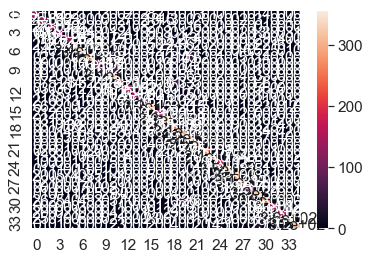

<Figure size 8000x8000 with 0 Axes>

In [73]:
#quantized_model_comparison(score,quantized_tflite_model,test_set, test_labels)
quantized_model_comparison(original_score,quantized_model,test_set, test_labels, label_encoder=training_encoder)

In [74]:
# Create float TFLite model.
float_converter = tf.lite.TFLiteConverter.from_keras_model(og_model)
float_tflite_model = float_converter.convert()

# Measure sizes of models.
_, float_file = tempfile.mkstemp('.tflite')
_, quant_file = tempfile.mkstemp('.tflite')

with open(quant_file, 'wb') as f:
  f.write(quantized_model)

with open(float_file, 'wb') as f:
  f.write(float_tflite_model)

print("Float model in Mb:", os.path.getsize(float_file) / float(2**20))
print("Quantized model in Mb:", os.path.getsize(quant_file) / float(2**20))

Float model in Mb: 0.0787353515625
Quantized model in Mb: 0.02594757080078125
